In [1]:
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
import tensorflow as tf
from keras import backend as K.`1
from keras.layers import Input
from keras.models import Model
from keras.backend.tensorflow_backend import set_session
from keras_frcnn import roi_helpers
from skimage import data
from skimage.filters import unsharp_mask

Using TensorFlow backend.


In [3]:
import math
with open('config.pickle', 'rb') as f_in:
	C = pickle.load(f_in)

import keras_frcnn.vgg as nn

# turn off any data augmentation at test time

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False
C.num_rois=32
C.anchor_box_scales = [8,16,24,32,40,64,72,92,128,256]
C.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)],[2./math.sqrt(2), 3./math.sqrt(2)],[1./math.sqrt(2), 3./math.sqrt(2)]]


working_dir=os.getcwd()
img_path = os.path.join(working_dir,"images")

In [5]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = 480
	(height,width,_) = img.shape

	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, img_min_side), interpolation=cv2.INTER_CUBIC)
	print (img.shape)
	return img,ratio

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	print (C.img_channel_mean[0])   
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img,ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [6]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}


num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)


{0: 'Streetlight', 1: 'Vehicle', 2: 'Walk_path', 3: 'Man', 4: 'Vehicle_front', 5: 'Woman', 6: 'Roof_light', 7: 'Banner', 8: 'Shop', 9: 'Building', 10: 'Window', 11: 'Man_bike', 12: 'Lights_off', 13: 'Street_shop', 14: 'dog', 15: 'Police', 16: 'children', 17: 'bg'}


In [7]:
model_path=os.path.join(working_dir,"model/Faster_RCNN_model.hdf5")
print('Loading weights')
model_rpn.load_weights(model_path, by_name=True)
model_classifier.load_weights(model_path, by_name=True)
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')
model_rpn.summary()
model_classifier.summary()

all_imgs = []

classes = {}

bbox_threshold = 0.5

visualise = True

Loading weights
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________

In [38]:
st=0
for idx, img_name in enumerate((os.listdir(img_path))):
	if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
		continue
	print(img_name)
	st = st+1
	filepath = os.path.join(img_path,'IMG_20201109_191530-17720.jpg')

	img = cv2.imread(filepath)
#below are some image enhancement techniques used
	#img = improve_contrast_image_using_clahe(img)

	#img = unsharp_mask(img)

	X, ratio = format_img(img, C)


	if K.common.image_dim_ordering() == 'tf':
		X = np.transpose(X, (0, 2, 3, 1))

	# get the feature maps and output from the RPN
	[Y1, Y2, F] = model_rpn.predict(X)
	

	R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.common.image_dim_ordering(), overlap_thresh=0.9)

	# convert from (x1,y1,x2,y2) to (x,y,w,h)
	R[:, 2] -= R[:, 0]
	R[:, 3] -= R[:, 1]

	# apply the spatial pyramid pooling to the proposed regions
	bboxes = {}
	probs = {}

	for jk in range(R.shape[0]//C.num_rois + 1):
		ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
		if ROIs.shape[1] == 0:
			break

		if jk == R.shape[0]//C.num_rois:
			#pad R
			curr_shape = ROIs.shape
			target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
			ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
			ROIs_padded[:, :curr_shape[1], :] = ROIs
			ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
			ROIs = ROIs_padded

		[P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

		for ii in range(P_cls.shape[1]):
			print (class_mapping[np.argmax(P_cls[0, ii, :])])
			if np.max(P_cls[0, ii, :]) < .2 or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
				continue

			cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

			if cls_name not in bboxes:
				bboxes[cls_name] = []
				probs[cls_name] = []

			(x, y, w, h) = ROIs[0, ii, :]

			cls_num = np.argmax(P_cls[0, ii, :])
			try:
				(tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
				tx /= C.classifier_regr_std[0]
				ty /= C.classifier_regr_std[1]
				tw /= C.classifier_regr_std[2]
				th /= C.classifier_regr_std[3]
				x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
			except:
				pass
			bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
			probs[cls_name].append(np.max(P_cls[0, ii, :]))

	all_dets = []
	print (bboxes)

	for key in bboxes:
		bbox = np.array(bboxes[key])

		new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
		for jk in range(new_boxes.shape[0]):
			(x1, y1, x2, y2) = new_boxes[jk,:]

			(real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

			cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

			textLabel = key
			all_dets.append((key,100*new_probs[jk]))

			(retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
			textOrg = (real_x1, real_y1-0)

			cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
			cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
			cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
        

	#print(f'Elapsed time = {time.time() - st)}')
	print(all_dets)
	if st==1:
		break


IMG_20201105_194521-17656.jpg
(480, 853, 3)
70.16324390928746
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
Walk_path
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
Walk_path
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Walk_path
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
bg
Wa

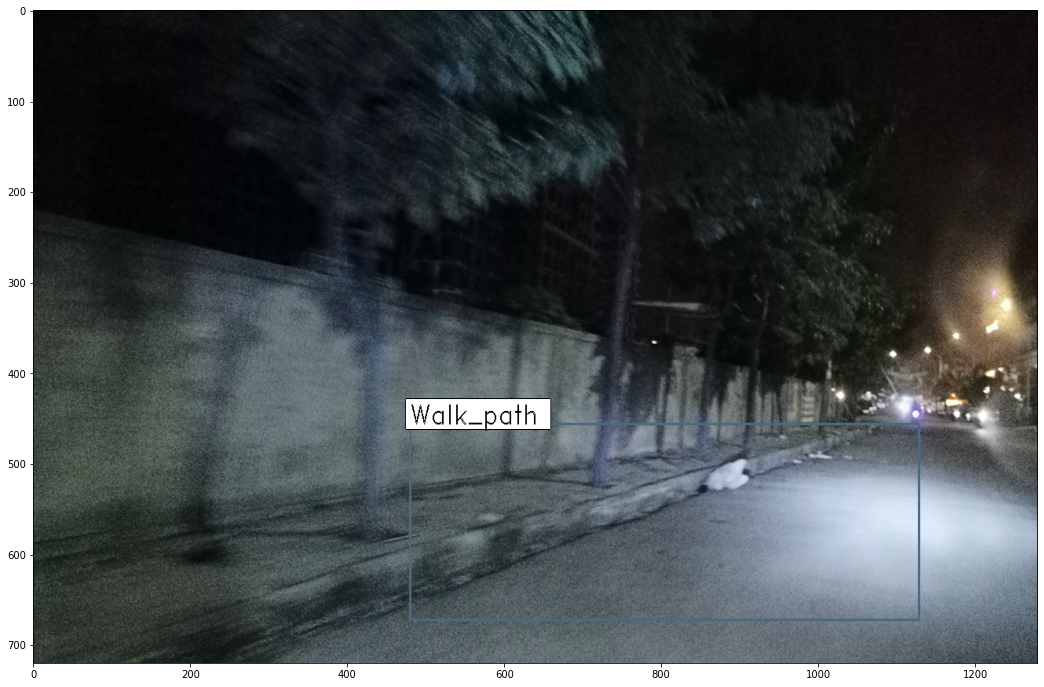

In [39]:
from matplotlib.pyplot import imshow,subplots
import numpy as np
from PIL import Image

%matplotlib inline
fig, ax = subplots(figsize=(18, 12))
imshow(img,aspect='auto')